In [20]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import timeit
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


### Data Preparation

#### create generator of infected and uninfected images

In [3]:
infected = (image for image in os.listdir('Parasitized'))
uninfected = (image for image in os.listdir('Uninfected'))
data = []
labels = []


#### run this block if loading cell and label data from previous run

In [3]:
cells, labels = load_data()


#### convert images to grayscale, and resize to 50x50 

In [4]:
def transform_images():
    """ convert color images to grayscale, resize"""
    for img in infected:
        # image = cv2.imread('./Parasitized/' + img)
        image = cv2.imread('./Parasitized/' + img, cv2.IMREAD_GRAYSCALE)
        image_array = Image.fromarray(image)  # create PIL image
        resize_img = image_array.resize((50, 50))  # returns resized copy of image
        """
        blurring the image reduces noise 
        Blurs/smooths an image using the normalized box filter
        """
        # blur_image = cv2.blur(np.array(resize_img), (50,50))
        data.append(np.array(resize_img))
        labels.append(1)

    for img in uninfected:
        # image = cv2.imread('./Uninfected/' + img)
        image = cv2.imread('./Uninfected/' + img, cv2.IMREAD_GRAYSCALE)
        image_array = Image.fromarray(image)  # create PIL image
        resize_img = image_array.resize((50, 50))  # returns resized copy of image
        # blur_image = cv2.blur(np.array(resize_img), (50,50))
        data.append(np.array(resize_img))
        labels.append(0)
        
transform_images()


#### convert to numpy ndarray

In [5]:
cells = np.array(data).astype('float64')
labels = np.array(labels).astype('float64')


#### inspect images

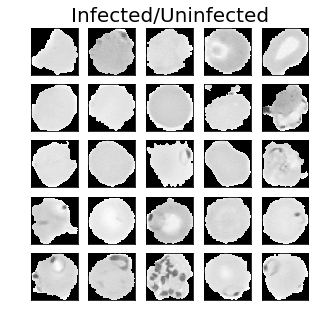

In [6]:
def inspect_images():
    np.random.seed(155)
    random_25 = np.random.randint(0,cells.shape[0], size=25)
    fig=plt.figure(figsize=(5,5))
    plt.title("Infected/Uninfected",fontsize=20)
    plt.axis('off')
    for ind,rand in enumerate(random_25):
        ax_n=fig.add_subplot(5,5,ind+1)
        ax_n.imshow(cells[rand],cmap=plt.cm.gray)
        ax_n.get_xaxis().set_visible(False)
        ax_n.get_yaxis().set_visible(False)
    plt.show()
inspect_images()


#### save ndarray to disk

In [7]:
np.save('Cells', cells, allow_pickle=False) 
np.save('Labels', labels, allow_pickle=False) 


In [44]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))


Cells : (27558, 50, 50) | labels : (27558,)


#### flatten the 50x50x3 or 50x50 dimensions into a feature vector of 7500 or 2500 values 
+ demensions for color images are 50x50x3 and 50x50 for grayscale

In [5]:
# cells_flattened = cells[:].reshape(-1,7500)
cells_flattened = cells[:].reshape(27558,2500)

In [17]:
cells_flattened.shape


(27558, 2500)

#### create train/test dataset

In [6]:
x_train, x_validation, y_train, y_validation = train_test_split(cells_flattened, labels, train_size=0.9, test_size=0.1, random_state=155)


### Use grid search to find best hyperparameters for KNN

In [21]:
def grid_search(X, y):
    standardized_data = StandardScaler()
    var_filter = VarianceThreshold()
    knn = KNeighborsClassifier()
    pipe = Pipeline([('standardized_data', standardized_data),
                     ('var_filter', var_filter),
                     ('knn', knn)])
    
    parameters = [{'knn__n_neighbors':[1,2,3,4,5], 'knn__algorithm':['brute'], 'knn__metric':['euclidean']}]
    grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=4, scoring='accuracy')
    
    start = timeit.default_timer()
    grid_search.fit(X, y)
    print(f'Runtime for KNN:{timeit.default_timer() - start}')
    return grid_search


#### get best model returned from grid search

In [22]:
knn_model = grid_search(x_train, y_train) 


Runtime for KNN:487.17083713500006


#### get best model and mean score from grid search 

In [23]:
print(knn_model.best_params_)
knn_model.cv_results_['mean_test_score']
    

{'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 1}


array([0.58563825, 0.54185146, 0.57330054, 0.54769777, 0.56870414])

### Performance metrics

In [27]:
results = knn_model.predict(x_validation)

In [28]:
confusion_matrix(y_validation, results)

array([[1209,  188],
       [ 935,  424]])

In [29]:
print(f"Accuracy: {accuracy_score(y_validation, results)}")
print(f"Recall: {recall_score(y_validation, results)}")
print(classification_report(y_validation, results))

Accuracy: 0.5925253991291727
Recall: 0.31199411331861665
              precision    recall  f1-score   support

           0       0.56      0.87      0.68      1397
           1       0.69      0.31      0.43      1359

   micro avg       0.59      0.59      0.59      2756
   macro avg       0.63      0.59      0.56      2756
weighted avg       0.63      0.59      0.56      2756

